In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime

In [2]:
# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

In [3]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }
   

In [4]:
class BERTClassifier(nn.Module):
    """
    A classifier model based on BERT for multi-label classification.
    
    This model uses a pre-trained BERT model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in BERT
        for param in self.bert.parameters():
            param.requires_grad = False
        # Unfreeze pooler parameters for fine-tuning
        for param in self.bert.pooler.parameters():
            param.requires_grad = True
        # Unfreeze parameters of the last 3 encoder layers
        for layer in self.bert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(pooled_output)
   

In [5]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


In [6]:

def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
 

In [7]:
def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)


In [8]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig


In [9]:
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels


In [10]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with BERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        if i < 20:  # Show only the top 20 combinations
            print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': mlb.classes_.tolist()
        }, f)
    
    # Calculate label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = BERTClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'text_column': args.text_column,
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }


Using 2 GPUs: [0, 1]
Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 0 occurrences: 109
Removed 0 infrequent label combinations
Final number of samples after all filtering: 1222

 Label Distribution : 
0. area/kubelet: 372
1. area/test: 326
2. area/apiserver: 223
3. area/cloudprovider: 194
4. area/kubectl: 145
5. area/dependency: 77
6. area/provider/azure: 67
7. area/code-generation: 54
8. area/kubeadm: 47
9. area/ipvs: 47
10. area/kube-proxy: 30
11. area/provider/gcp: 29
12. area/e2e-test-framework: 23
13. area/release-eng: 18
14. area/conformance: 16
15. area/custom-resources: 16
16. area/security: 11
17. area/provider/vmware: 6
18. area/etcd: 5
19. area/provider/openstack: 5

 Label count per row distribution:
Label: 1, count: 888
Label: 2, count:

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using larger batch size of 32 for 2 GPUs
Initializing model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model wrapped in DataParallel
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Train Loss: 0.5393, Train Accuracy (Exact Match): 0.0113
Val Loss: 0.3719
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
Saved initial model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt as baseline

Epoch 2/20


Training: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Train Loss: 0.3232, Train Accuracy (Exact Match): 0.0010
Val Loss: 0.2675
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 3/20


Training: 100%|██████████| 31/31 [00:31<00:00,  1.03s/it]


Train Loss: 0.2565, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2315
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 4/20


Training: 100%|██████████| 31/31 [00:33<00:00,  1.10s/it]


Train Loss: 0.2299, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2161
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 5/20


Training: 100%|██████████| 31/31 [00:35<00:00,  1.13s/it]


Train Loss: 0.2145, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.2073
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Partial Match): 0.0000
Val Accuracy (Jaccard): 0.0000
Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000

Epoch 6/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.2023, Train Accuracy (Exact Match): 0.0133
Val Loss: 0.1988
Val Accuracy (Exact Match): 0.0735
Val Accuracy (Partial Match): 0.0803
Val Accuracy (Jaccard): 0.0803
Val Precision: 0.0898, Val Recall: 0.0803, Val F1: 0.0830
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 7/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1908, Train Accuracy (Exact Match): 0.1003
Val Loss: 0.1904
Val Accuracy (Exact Match): 0.2367
Val Accuracy (Partial Match): 0.2709
Val Accuracy (Jaccard): 0.2709
Val Precision: 0.3143, Val Recall: 0.2709, Val F1: 0.2834
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 8/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1778, Train Accuracy (Exact Match): 0.2027
Val Loss: 0.1827
Val Accuracy (Exact Match): 0.2980
Val Accuracy (Partial Match): 0.3506
Val Accuracy (Jaccard): 0.3493
Val Precision: 0.4082, Val Recall: 0.3506, Val F1: 0.3680
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 9/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1662, Train Accuracy (Exact Match): 0.2794
Val Loss: 0.1756
Val Accuracy (Exact Match): 0.3224
Val Accuracy (Partial Match): 0.3891
Val Accuracy (Jaccard): 0.3827
Val Precision: 0.4449, Val Recall: 0.3891, Val F1: 0.4047
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 10/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1561, Train Accuracy (Exact Match): 0.3388
Val Loss: 0.1672
Val Accuracy (Exact Match): 0.3551
Val Accuracy (Partial Match): 0.4259
Val Accuracy (Jaccard): 0.4184
Val Precision: 0.4816, Val Recall: 0.4259, Val F1: 0.4411
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 11/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1460, Train Accuracy (Exact Match): 0.4063
Val Loss: 0.1601
Val Accuracy (Exact Match): 0.3796
Val Accuracy (Partial Match): 0.4544
Val Accuracy (Jaccard): 0.4477
Val Precision: 0.5122, Val Recall: 0.4544, Val F1: 0.4709
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 12/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1356, Train Accuracy (Exact Match): 0.4391
Val Loss: 0.1565
Val Accuracy (Exact Match): 0.3837
Val Accuracy (Partial Match): 0.5037
Val Accuracy (Jaccard): 0.4724
Val Precision: 0.5339, Val Recall: 0.5037, Val F1: 0.5029
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 13/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1292, Train Accuracy (Exact Match): 0.4995
Val Loss: 0.1513
Val Accuracy (Exact Match): 0.3796
Val Accuracy (Partial Match): 0.5020
Val Accuracy (Jaccard): 0.4749
Val Precision: 0.5449, Val Recall: 0.5020, Val F1: 0.5066
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 14/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1210, Train Accuracy (Exact Match): 0.5046
Val Loss: 0.1465
Val Accuracy (Exact Match): 0.3878
Val Accuracy (Partial Match): 0.5088
Val Accuracy (Jaccard): 0.4803
Val Precision: 0.5490, Val Recall: 0.5088, Val F1: 0.5117
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 15/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1138, Train Accuracy (Exact Match): 0.5435
Val Loss: 0.1454
Val Accuracy (Exact Match): 0.3918
Val Accuracy (Partial Match): 0.5171
Val Accuracy (Jaccard): 0.4857
Val Precision: 0.5524, Val Recall: 0.5171, Val F1: 0.5180
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 16/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.1089, Train Accuracy (Exact Match): 0.5722
Val Loss: 0.1438
Val Accuracy (Exact Match): 0.4327
Val Accuracy (Partial Match): 0.5617
Val Accuracy (Jaccard): 0.5269
Val Precision: 0.5894, Val Recall: 0.5617, Val F1: 0.5592
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 17/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.1028, Train Accuracy (Exact Match): 0.5947
Val Loss: 0.1413
Val Accuracy (Exact Match): 0.3959
Val Accuracy (Partial Match): 0.5269
Val Accuracy (Jaccard): 0.4912
Val Precision: 0.5540, Val Recall: 0.5269, Val F1: 0.5242

Epoch 18/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0978, Train Accuracy (Exact Match): 0.6039
Val Loss: 0.1363
Val Accuracy (Exact Match): 0.4286
Val Accuracy (Partial Match): 0.5644
Val Accuracy (Jaccard): 0.5263
Val Precision: 0.5911, Val Recall: 0.5644, Val F1: 0.5599
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 19/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


Train Loss: 0.0936, Train Accuracy (Exact Match): 0.6285
Val Loss: 0.1369
Val Accuracy (Exact Match): 0.4449
Val Accuracy (Partial Match): 0.5821
Val Accuracy (Jaccard): 0.5470
Val Precision: 0.6169, Val Recall: 0.5821, Val F1: 0.5810
Saved new best model to ./results/run_20250317_062951_all_text_0.5/best_model_all_text_0.5.pt

Epoch 20/20


Training: 100%|██████████| 31/31 [00:34<00:00,  1.12s/it]


Train Loss: 0.0892, Train Accuracy (Exact Match): 0.6448
Val Loss: 0.1313
Val Accuracy (Exact Match): 0.4327
Val Accuracy (Partial Match): 0.5650
Val Accuracy (Jaccard): 0.5303
Val Precision: 0.5972, Val Recall: 0.5650, Val F1: 0.5633

Loading best model for final evaluation...


<ipython-input-10-0d30d61b65d5>:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4449
Partial Match Accuracy: 0.5821
Jaccard Similarity: 0.5470
Precision: 0.6169
Recall: 0.5821
F1 Score: 0.5810

Training completed! Results saved to ./results/run_20250317_062951_all_text_0.5


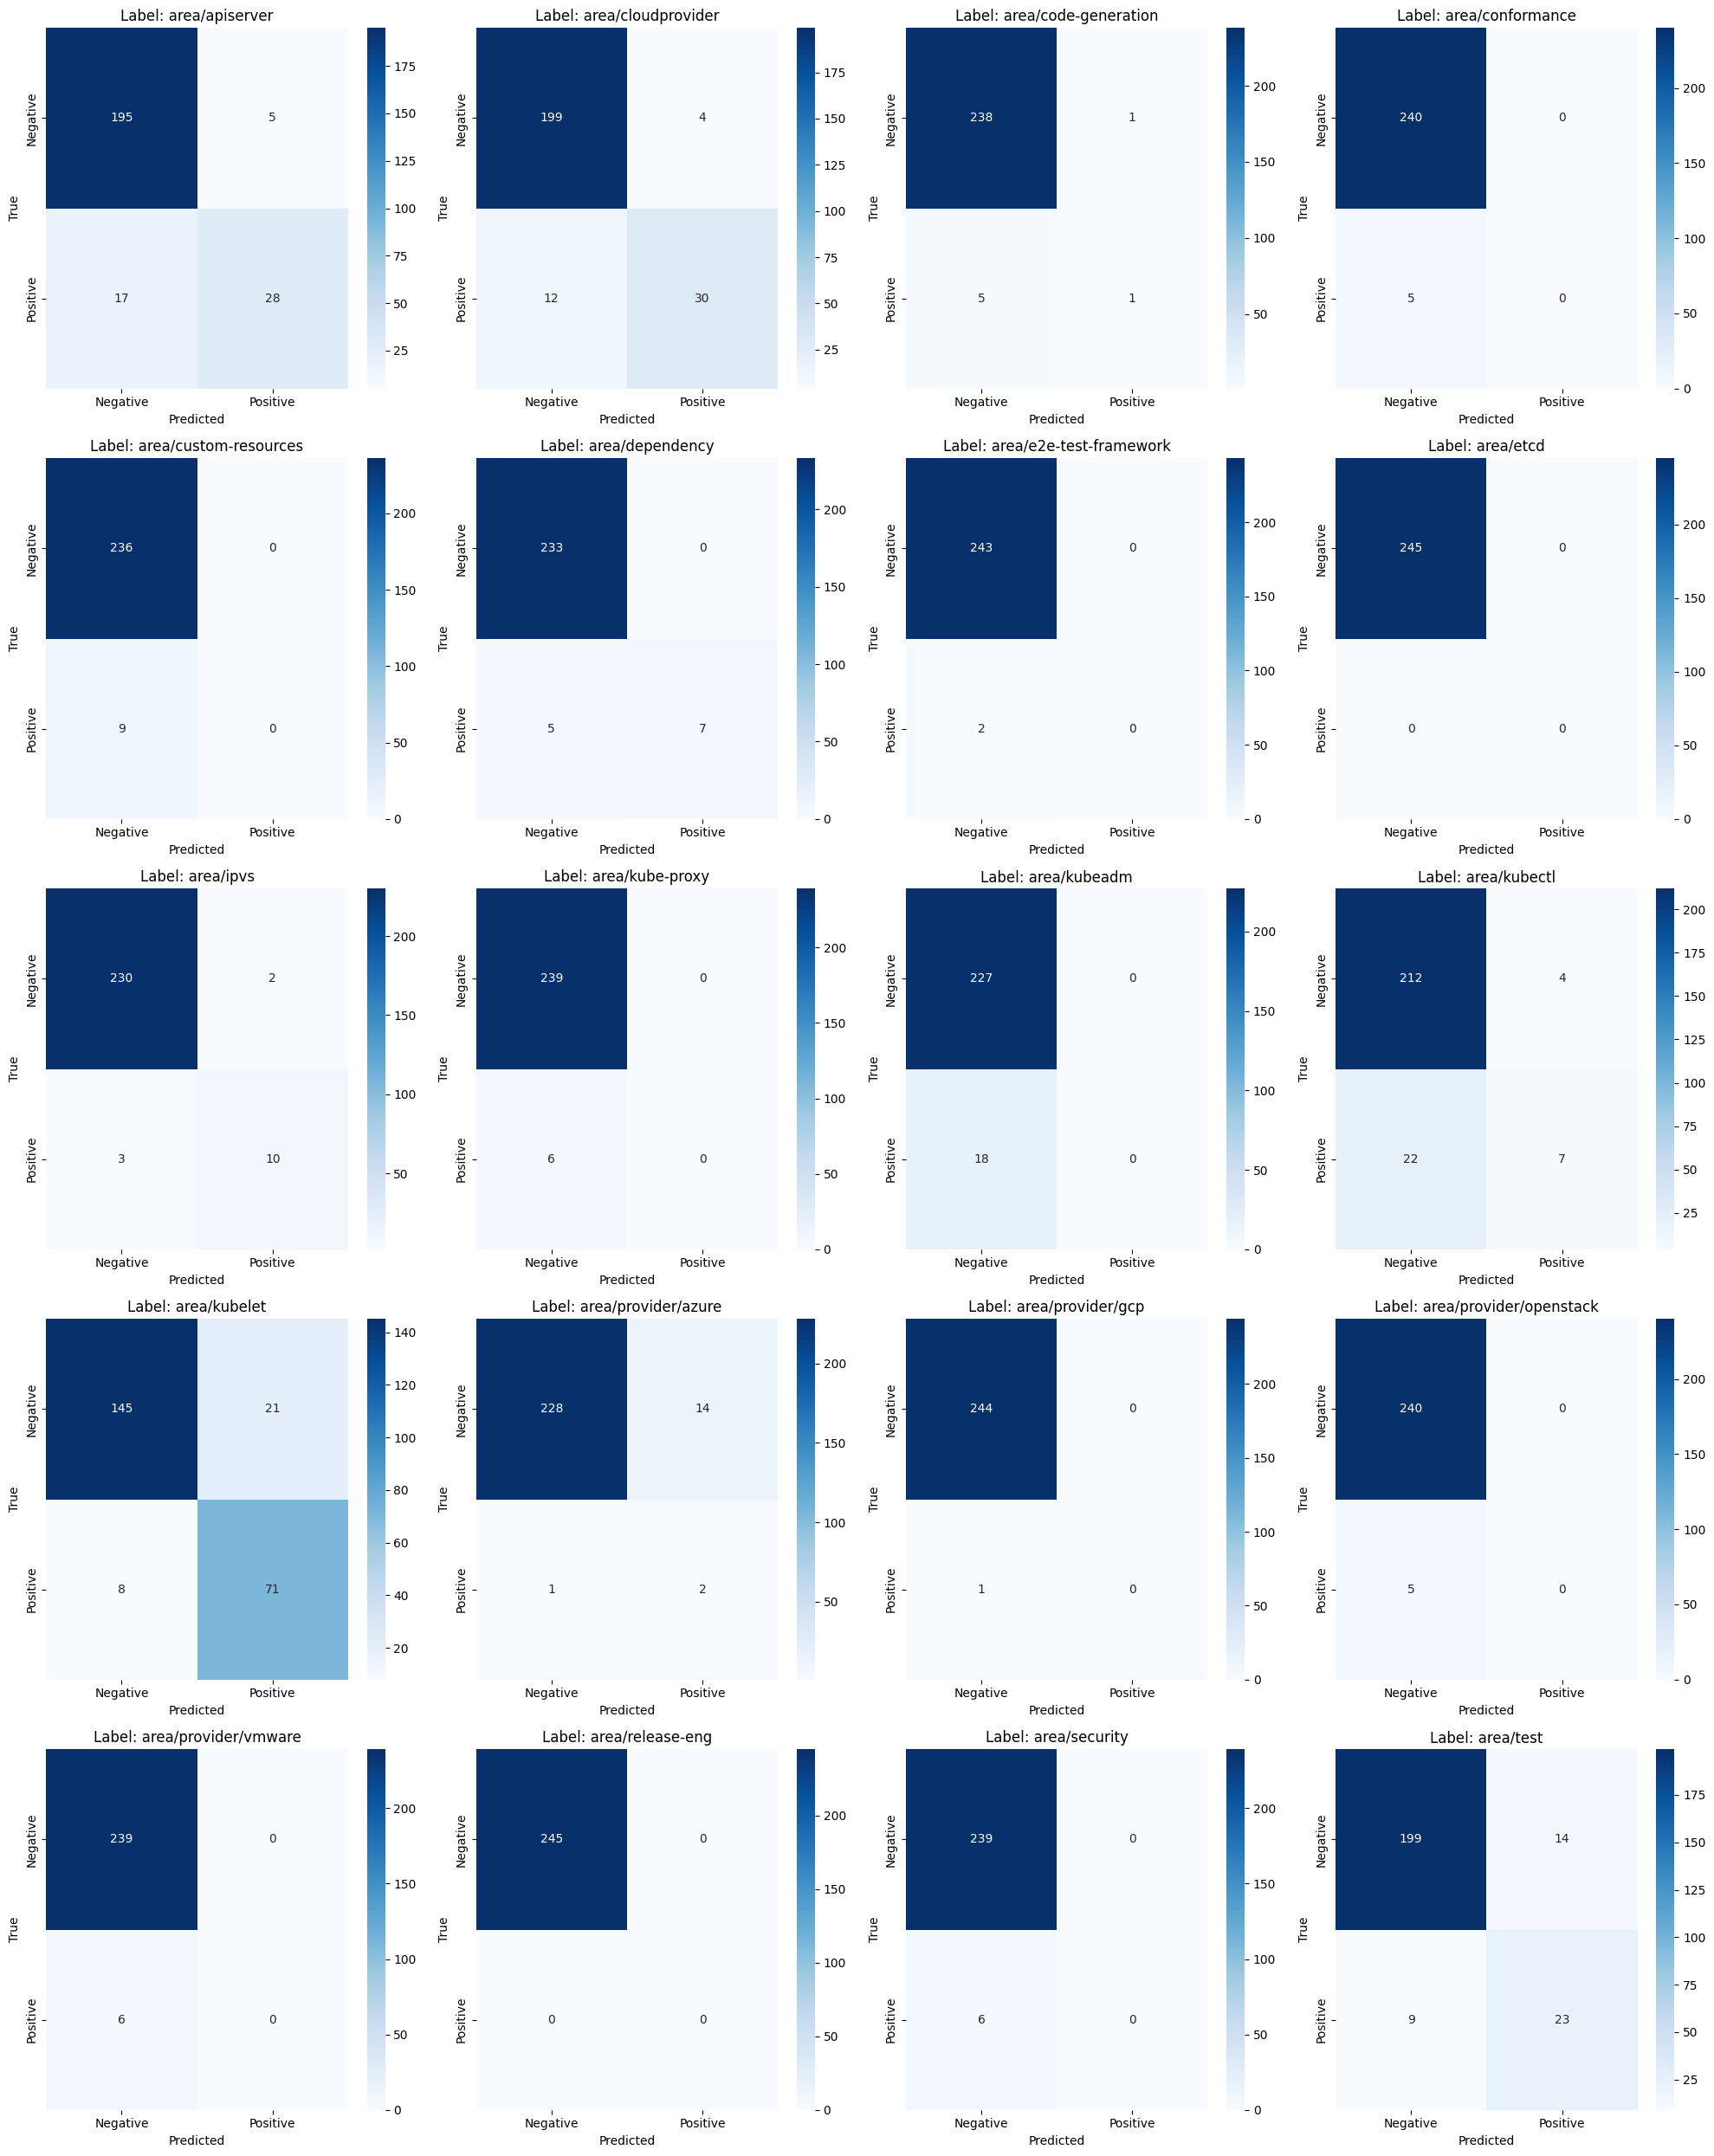

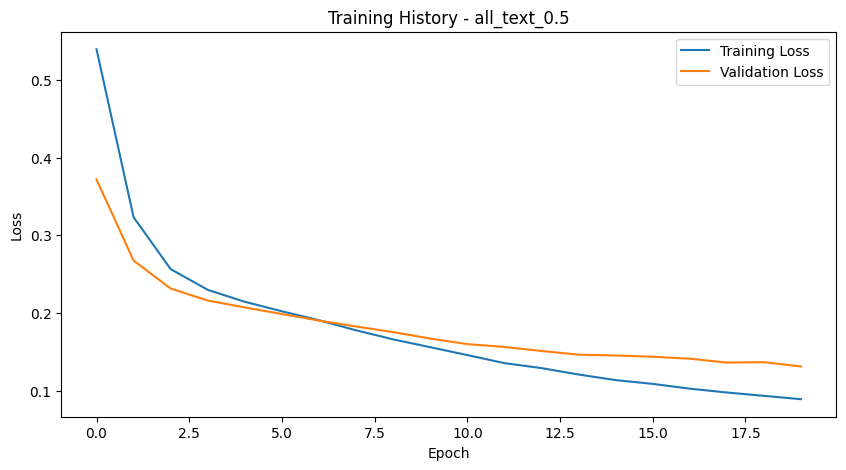

In [11]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train BERT for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=0,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=20, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=3, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args) 